In [1]:
# gym game title
GAME_TITLE = 'SpaceInvaders-v0'

# how many parallel game instances to play simultaneously.
N_PARALLEL_GAMES = 4

# how long is one replay session from a batch
# since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 50

#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=cpu'

env: THEANO_FLAGS='device=cpu'


# This is basic tutorial on using AgentNet to play OpenAI Gym games

Basic setup is following:

* Space Invaders game as an example
* Training a very simple lasagne neural network for Q_learning objective
 
* Training via simple experience replay (explained below)
* TODO не понял Only using utility recurrent layers for simplicity of this example
 * but adding a few RNNs or GRUs shouldn's be a problem
* the network is trained with a simple one-step Q-learning for simplicity


## About OpenAI Gym

[OpenAI Gym](https://github.com/openai/gym) is a recently published platform ([github]) that basicly allows you to train agents in a wide variety of environments with almost identical interface.

Thanks to Gym, now we don't need to write a new wrapper for every game!

  
### Installing OpenAI Gym

```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

## Lasagne

AgentNet trains neural network written in Lasagne to play games.

* Lasagne is quite simple, and you don't need to have deep knowledge of it.

* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb


# Experiment setup

How the game looks like. We only collect information (actions, shape of observation) at this step.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

[2016-05-18 14:19:21,339] Making new env: SpaceInvaders-v0


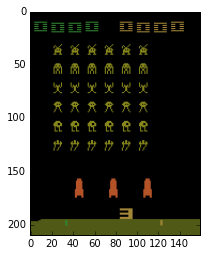

In [3]:
import gym
game = gym.make(GAME_TITLE)
game.reset()
plt.imshow(game.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [4]:
observation_shape = game.observation_space.shape
action_names = game.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [5]:
del game

# Agent setup step by step

* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "Previous memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - action picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
   
   
We can illustrate the process:

(one can assume that the 'time' goes from left to right, inputs are at the bottom and outputs go to the top)



![window_dqn_scheme](http://s32.postimg.org/yy5q3wadx/window_dqn.png)
  




##### Agent observations

* Here you define where observations (game images) appear in the network

In [6]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

In [7]:
# image observation at current tick goes here
observation_layer = InputLayer((None,) + observation_shape, name="images input")

# reshape [batch, x, y, color] to [batch, color, x, y], so that convolutional layers from Lasagne will work correctly
observation_reshape = DimshuffleLayer(observation_layer, (0,3,1,2))

  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


### In this demo

Since we have almost fully observable environment AND we want to keep baseline simple, we shall use no recurrent units.
However, Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.
To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.

One can try to use
 * GRU - `from agentnet.memory import GRUMemoryLayer`
 * RNN - `from agentnet.memory import RNNCell`
 * any custom lasagne layers that compute new memory states


In [8]:
# memory
# using simple window-based memory that stores several states
# the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation

window_size = 3

#prev state input
prev_window = InputLayer((None, window_size) + tuple(observation_reshape.output_shape[1:]),
                         name = "previous window state")


#our window
window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name="new window state")

##### Neural network body
Our strategy, again:
 * take pixel-wise maximum over the window
 * apply some layers
 * use output layer to predict Q-values(see next)

In [9]:
from lasagne.layers import DropoutLayer,DenseLayer, ExpressionLayer
#you may use any other lasagne layers, including convolutions, batch_norms, maxout, etc

#pixel-wise maximum over the temporal window (to avoid flickering)
window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,) + window.output_shape[2:])


#a simple lasagne network (try replacing with any other lasagne network and see what works best)    
nn = DenseLayer(window_max,num_units=100,name='dense0')
nn = DropoutLayer(nn, name = "dropout", p=0.1) #will get deterministic during evaluation
nn = DenseLayer(nn, num_units=300,name='dense1')

##### Agent policy and action picking
* Since we are training a deep Q-network, we need it to predict Q-values and take actions.
* Hence we define a lasagne layer that is used for action output

* To pick actions, we use an epsilon-greedy resolver
  * Note that resolver outputs particular action IDs and not probabilities.
  * These actions are than sent into the environment

In [10]:
# predicted Q-values
q_eval = DenseLayer(nn,
                    num_units=len(action_names),
                    nonlinearity=lasagne.nonlinearities.linear,
                    name="QEvaluator")

# resolver
from agentnet.resolver import EpsilonGreedyResolver
resolver = EpsilonGreedyResolver(q_eval,name="resolver")


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [11]:
from agentnet.agent import Agent
# all together
agent = Agent(observation_layer,
              state_variables={window:prev_window},
              policy=q_eval,
              action_layers=resolver)

# Agent step function
* computes action and next state given observation and prev state
* written in a generic way to support any recurrences, windows, LTMs, etc

In [12]:
#compile theano graph for one step decision making
applier_fun = agent.get_react_function()

#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype='float32') 
                         for mem in agent.state_variables]
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action, memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [13]:
from openai_gym_pool import GamePool

game_pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)

[2016-05-18 14:19:43,132] Making new env: SpaceInvaders-v0
[2016-05-18 14:19:43,160] Making new env: SpaceInvaders-v0
[2016-05-18 14:19:43,197] Making new env: SpaceInvaders-v0
[2016-05-18 14:19:43,231] Making new env: SpaceInvaders-v0


In [14]:
%%time
observation_log, action_log, reward_log,_,_,_  = game_pool.interact(step, 50)
print np.array(action_names)[np.array(action_log)[:3,:5]]

[['FIRE' 'FIRE' 'FIRE' 'FIRE' 'FIRE']
 ['FIRE' 'FIRE' 'FIRE' 'FIRE' 'LEFT']
 ['LEFT' 'FIRE' 'FIRE' 'RIGHT' 'FIRE']]
CPU times: user 1.45 s, sys: 486 ms, total: 1.93 s
Wall time: 2.23 s


# Experience replay pool

Experience replay is a common technique to gave stable training.

`AgentNet` provides `SessionPoolEnvironment` for experience replay.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat

In [15]:
# Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations=observation_layer,
                             actions=resolver,
                             agent_memories=agent.state_variables)

In [16]:
def update_pool(env, game_pool, n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(game_pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= game_pool.interact(step,n_steps=n_steps)
        
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)

In [17]:
#load first  sessions
update_pool(env, game_pool, replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [19]:
# the onl thing is Qvalues sequence.
_environment_state, _observation_sequences, _memory_units, _preferred_actions, qvalues_seq = agent.get_sessions(
    environment=env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [25]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later

# IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = env.rewards
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      env.actions[0],
                                                      scaled_reward_seq,
                                                      env.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()

In [26]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [27]:
loss = mse_loss + reg_l2

In [28]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [29]:
#mean session reward
mean_session_reward = env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [30]:
import theano
do_training_step = theano.function([], [loss,mean_session_reward], updates=updates)
evaluation_fun = theano.function([], [loss, mse_loss, reg_l2, mean_session_reward])

# Session visualization tools

Just a helper function that draws current game images.

In [31]:
def display_sessions(max_n_sessions = 3):
    """Just draw random images"""    
    plt.figure(figsize=[15, 8])
    
    pictures = [atari.render("rgb_array") for atari in game_pool.ataries[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

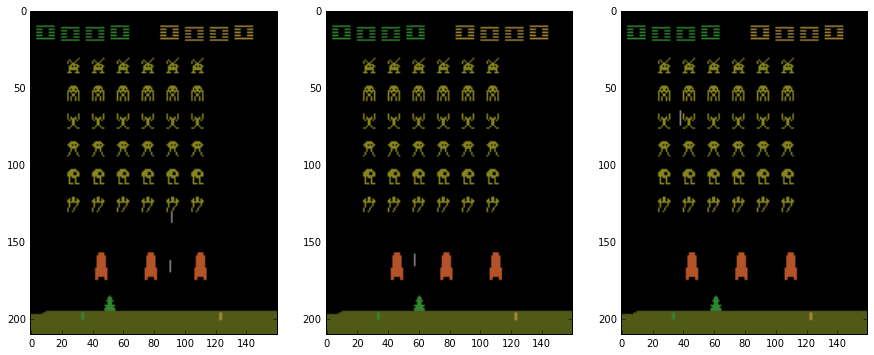

In [32]:
# visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [56]:
from collections import OrderedDict
score_log = OrderedDict()
score_log["expected e-greedy reward"] = list()
score_log["expected greedy reward"] = list()

In [54]:
# type(score_log)

In [55]:
# starting epoch
# epoch_counter = 1
# moving average estimation
# alpha = 0.1
# ma_reward_current = 0.
# ma_reward_greedy = 0.

epoch 10,loss 2378.29918, epsilon 0.49552, rewards: ( e-greedy 0.16667, greedy 0.16667) 
rec 2378.263 reg 0.036
epoch 20,loss 3249.61840, epsilon 0.49109, rewards: ( e-greedy 0.15000, greedy 0.31667) 
rec 3249.582 reg 0.036
epoch 30,loss 2340.62520, epsilon 0.48670, rewards: ( e-greedy 0.13500, greedy 0.28500) 
rec 2340.589 reg 0.036
epoch 40,loss 1026.35599, epsilon 0.48236, rewards: ( e-greedy 0.12150, greedy 0.25650) 
rec 1026.320 reg 0.036
epoch 50,loss 863.59936, epsilon 0.47805, rewards: ( e-greedy 0.10935, greedy 0.23085) 
rec 863.563 reg 0.036
epoch 60,loss 581.09296, epsilon 0.47379, rewards: ( e-greedy 0.09842, greedy 0.20777) 
rec 581.057 reg 0.036
epoch 70,loss 482.68457, epsilon 0.46958, rewards: ( e-greedy 0.42191, greedy 0.52032) 
rec 482.648 reg 0.036
epoch 80,loss 452.54478, epsilon 0.46540, rewards: ( e-greedy 0.37972, greedy 0.46829) 
rec 452.508 reg 0.036
epoch 90,loss 346.54303, epsilon 0.46127, rewards: ( e-greedy 0.84174, greedy 0.42146) 
rec 346.507 reg 0.036
ep

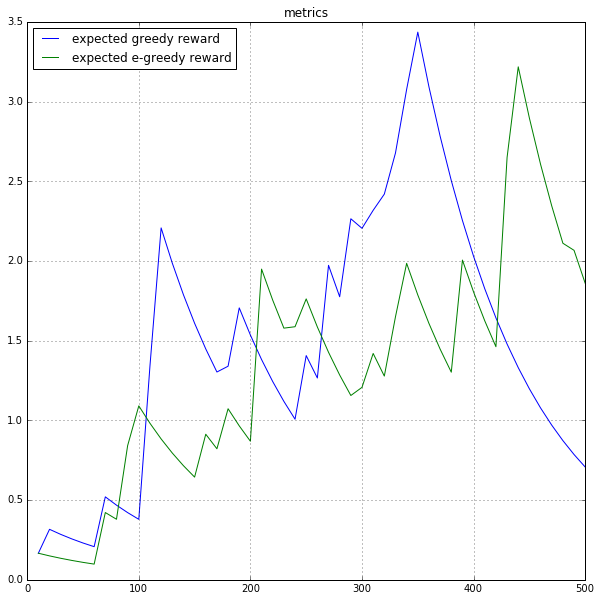

Random session examples


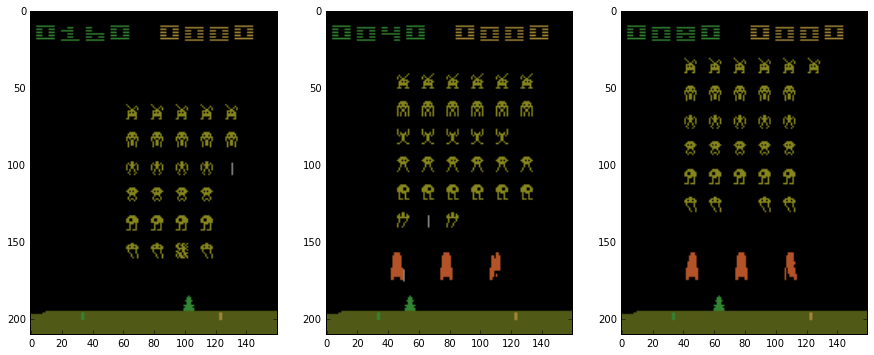

epoch 510,loss 0.03731, epsilon 0.32022, rewards: ( e-greedy 1.67393, greedy 0.63655) 
rec 0.001 reg 0.036
epoch 520,loss 0.07455, epsilon 0.31753, rewards: ( e-greedy 1.50654, greedy 0.57290) 
rec 0.038 reg 0.036
epoch 530,loss 0.03636, epsilon 0.31487, rewards: ( e-greedy 1.35589, greedy 0.51561) 
rec 0.000 reg 0.036
epoch 540,loss 0.51171, epsilon 0.31224, rewards: ( e-greedy 1.22030, greedy 0.46405) 
rec 0.475 reg 0.036
epoch 550,loss 0.03635, epsilon 0.30963, rewards: ( e-greedy 1.09827, greedy 1.25097) 
rec 0.000 reg 0.036
epoch 560,loss 0.03642, epsilon 0.30704, rewards: ( e-greedy 0.98844, greedy 1.12588) 
rec 0.000 reg 0.036
epoch 570,loss 1.06796, epsilon 0.30449, rewards: ( e-greedy 0.88960, greedy 1.01329) 
rec 1.032 reg 0.036
epoch 580,loss 0.03640, epsilon 0.30195, rewards: ( e-greedy 0.80064, greedy 0.91196) 
rec 0.000 reg 0.036
epoch 590,loss 0.03634, epsilon 0.29945, rewards: ( e-greedy 0.72057, greedy 0.82076) 
rec 0.000 reg 0.036
epoch 600,loss 0.03637, epsilon 0.296

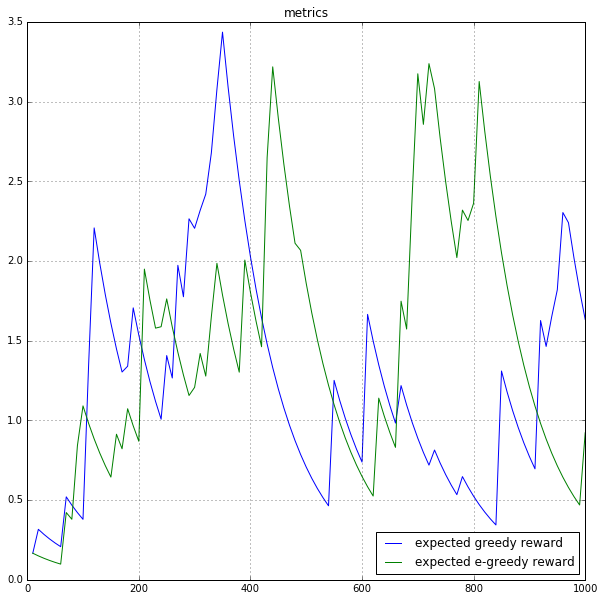

Random session examples


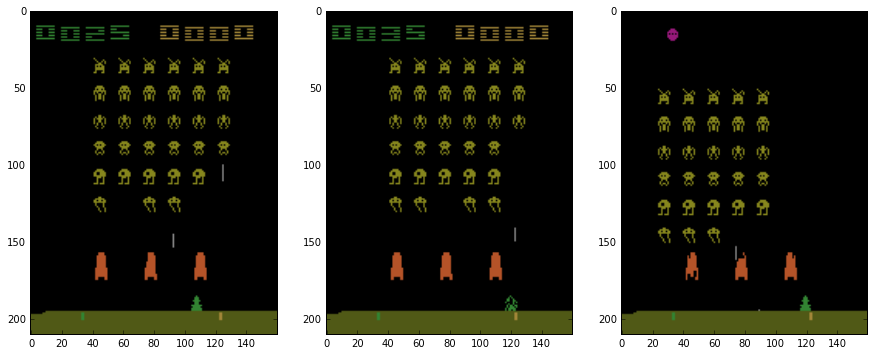

epoch 1010,loss 0.03655, epsilon 0.21390, rewards: ( e-greedy 0.82999, greedy 1.46968) 
rec 0.000 reg 0.036
epoch 1020,loss 13.40122, epsilon 0.21227, rewards: ( e-greedy 1.41366, greedy 1.32272) 
rec 13.365 reg 0.036
epoch 1030,loss 0.03654, epsilon 0.21065, rewards: ( e-greedy 1.27230, greedy 1.19044) 
rec 0.000 reg 0.036
epoch 1040,loss 0.03658, epsilon 0.20905, rewards: ( e-greedy 1.14507, greedy 1.07140) 
rec 0.000 reg 0.036
epoch 1050,loss 0.03658, epsilon 0.20747, rewards: ( e-greedy 1.03056, greedy 0.96426) 
rec 0.000 reg 0.036
epoch 1060,loss 0.03651, epsilon 0.20591, rewards: ( e-greedy 0.92750, greedy 1.70117) 
rec 0.000 reg 0.036
epoch 1070,loss 0.03650, epsilon 0.20435, rewards: ( e-greedy 0.83475, greedy 1.53105) 
rec 0.000 reg 0.036
epoch 1080,loss 0.03636, epsilon 0.20282, rewards: ( e-greedy 0.75128, greedy 1.87795) 
rec 0.000 reg 0.036
epoch 1090,loss 0.03658, epsilon 0.20130, rewards: ( e-greedy 0.67615, greedy 1.69015) 
rec 0.000 reg 0.036
epoch 1100,loss 3.33689, e

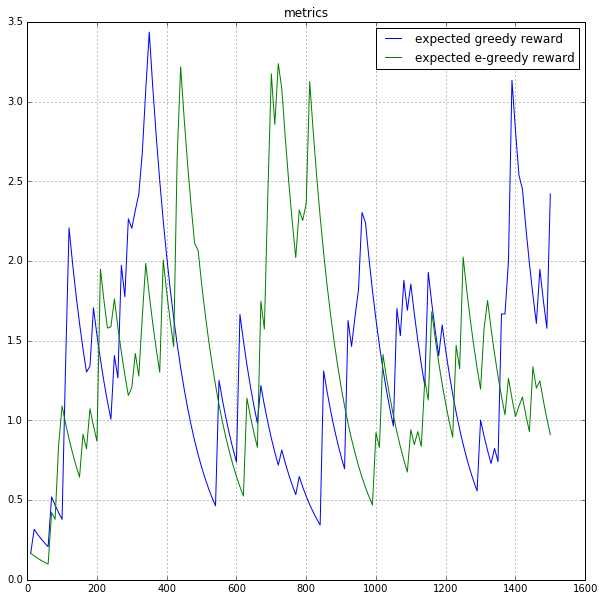

Random session examples


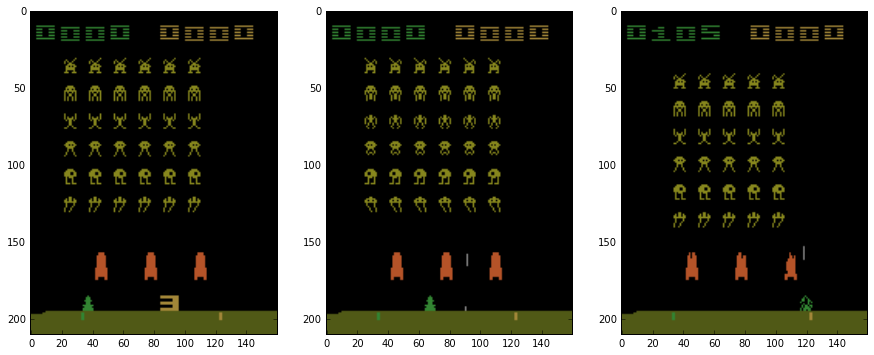

epoch 1510,loss 0.03651, epsilon 0.14941, rewards: ( e-greedy 0.81912, greedy 2.17770) 
rec 0.000 reg 0.036
epoch 1520,loss 0.03668, epsilon 0.14842, rewards: ( e-greedy 0.73721, greedy 1.95993) 
rec 0.001 reg 0.036
epoch 1530,loss 0.03688, epsilon 0.14744, rewards: ( e-greedy 0.66349, greedy 1.76394) 
rec 0.001 reg 0.036
epoch 1540,loss 0.03674, epsilon 0.14647, rewards: ( e-greedy 0.59714, greedy 1.58754) 
rec 0.001 reg 0.036
epoch 1550,loss 0.87005, epsilon 0.14551, rewards: ( e-greedy 0.70409, greedy 1.42879) 
rec 0.834 reg 0.036
epoch 1560,loss 0.03673, epsilon 0.14456, rewards: ( e-greedy 0.63368, greedy 1.78591) 
rec 0.001 reg 0.036
epoch 1570,loss 30.13933, epsilon 0.14362, rewards: ( e-greedy 1.57032, greedy 1.60732) 
rec 30.103 reg 0.036
epoch 1580,loss 7.53623, epsilon 0.14269, rewards: ( e-greedy 1.91328, greedy 1.44659) 
rec 7.500 reg 0.036
epoch 1590,loss 0.03683, epsilon 0.14177, rewards: ( e-greedy 1.72196, greedy 1.30193) 
rec 0.001 reg 0.036
epoch 1600,loss 0.03683, e

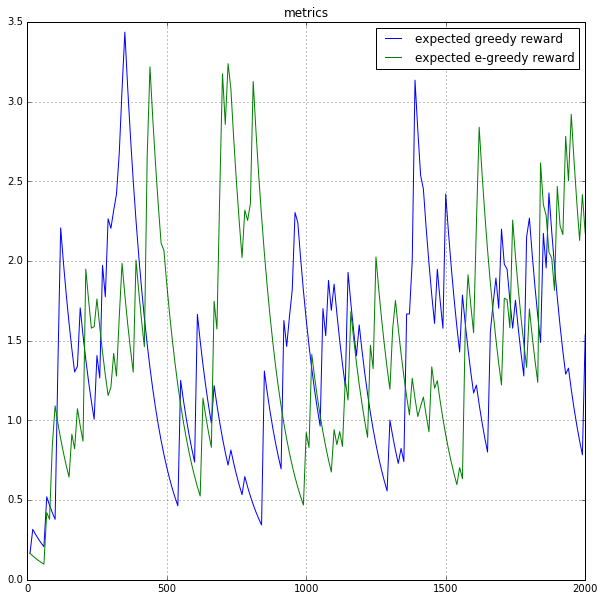

Random session examples


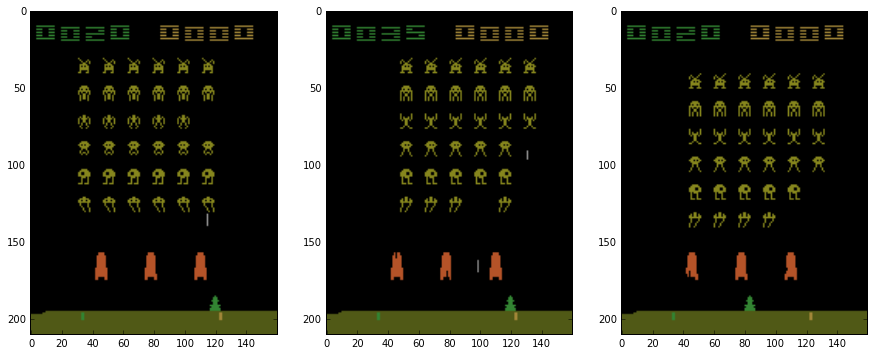

epoch 2010,loss 0.03688, epsilon 0.11029, rewards: ( e-greedy 1.95683, greedy 1.38490) 
rec 0.001 reg 0.036
epoch 2020,loss 0.03745, epsilon 0.10969, rewards: ( e-greedy 1.76115, greedy 1.24641) 
rec 0.001 reg 0.036
epoch 2030,loss 0.03726, epsilon 0.10910, rewards: ( e-greedy 1.58503, greedy 1.12177) 
rec 0.001 reg 0.036
epoch 2040,loss 0.03751, epsilon 0.10851, rewards: ( e-greedy 1.42653, greedy 1.00959) 
rec 0.001 reg 0.036
epoch 2050,loss 0.03727, epsilon 0.10793, rewards: ( e-greedy 1.28388, greedy 0.90863) 
rec 0.001 reg 0.036
epoch 2060,loss 0.03700, epsilon 0.10735, rewards: ( e-greedy 1.15549, greedy 0.81777) 
rec 0.001 reg 0.036
epoch 2070,loss 0.03739, epsilon 0.10678, rewards: ( e-greedy 1.03994, greedy 0.73599) 
rec 0.001 reg 0.036
epoch 2080,loss 0.03745, epsilon 0.10622, rewards: ( e-greedy 0.93595, greedy 0.66239) 
rec 0.001 reg 0.036
epoch 2090,loss 0.03744, epsilon 0.10566, rewards: ( e-greedy 0.84235, greedy 0.59615) 
rec 0.001 reg 0.036
epoch 2100,loss 0.03763, eps

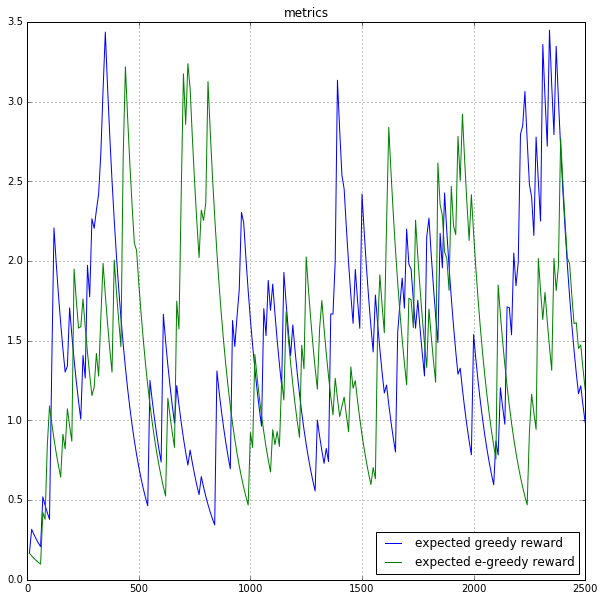

Random session examples


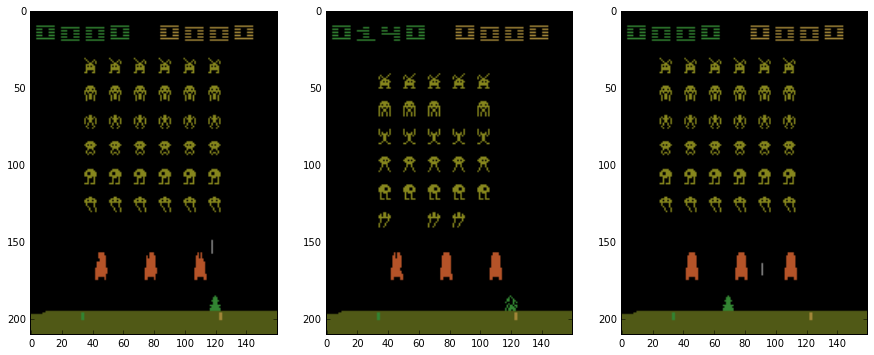

epoch 2510,loss 0.03820, epsilon 0.08657, rewards: ( e-greedy 1.07388, greedy 1.22048) 
rec 0.002 reg 0.036
epoch 2520,loss 0.03819, epsilon 0.08621, rewards: ( e-greedy 0.96649, greedy 1.09843) 
rec 0.002 reg 0.036
epoch 2530,loss 0.03783, epsilon 0.08585, rewards: ( e-greedy 0.86984, greedy 0.98859) 
rec 0.002 reg 0.036
epoch 2540,loss 0.03762, epsilon 0.08549, rewards: ( e-greedy 0.78286, greedy 1.72306) 
rec 0.002 reg 0.036
epoch 2550,loss 0.03796, epsilon 0.08514, rewards: ( e-greedy 0.70457, greedy 1.55076) 
rec 0.002 reg 0.036
epoch 2560,loss 0.03765, epsilon 0.08479, rewards: ( e-greedy 0.63411, greedy 1.39568) 
rec 0.002 reg 0.036
epoch 2570,loss 0.03751, epsilon 0.08444, rewards: ( e-greedy 0.57070, greedy 1.25611) 
rec 0.002 reg 0.036
epoch 2580,loss 0.03766, epsilon 0.08410, rewards: ( e-greedy 0.51363, greedy 1.13050) 
rec 0.002 reg 0.036
epoch 2590,loss 0.03785, epsilon 0.08376, rewards: ( e-greedy 0.46227, greedy 1.01745) 
rec 0.002 reg 0.036
epoch 2600,loss 0.03799, eps

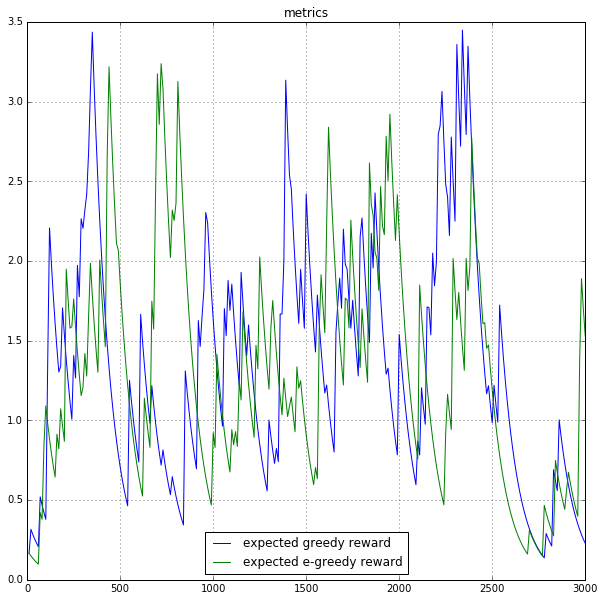

Random session examples


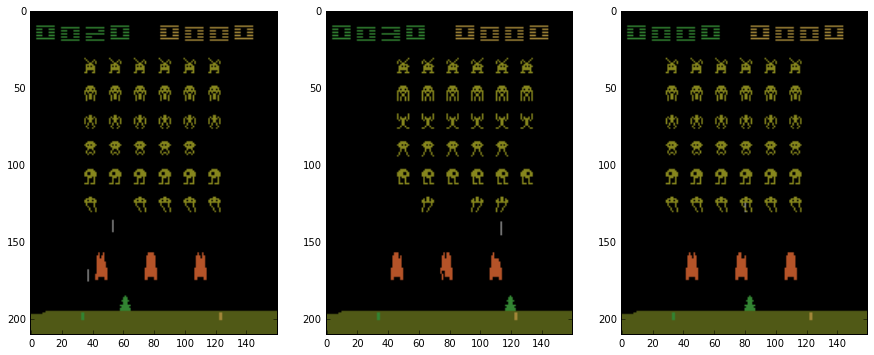

epoch 3010,loss 0.03827, epsilon 0.07218, rewards: ( e-greedy 1.37734, greedy 0.20659) 
rec 0.002 reg 0.036
epoch 3020,loss 0.03885, epsilon 0.07196, rewards: ( e-greedy 1.23960, greedy 0.18593) 
rec 0.003 reg 0.036
epoch 3030,loss 0.03873, epsilon 0.07174, rewards: ( e-greedy 1.11564, greedy 0.16734) 
rec 0.003 reg 0.036
epoch 3040,loss 0.03915, epsilon 0.07153, rewards: ( e-greedy 1.00408, greedy 0.98394) 
rec 0.003 reg 0.036
epoch 3050,loss 0.03903, epsilon 0.07131, rewards: ( e-greedy 0.90367, greedy 0.88554) 
rec 0.003 reg 0.036
epoch 3060,loss 0.03955, epsilon 0.07110, rewards: ( e-greedy 0.81330, greedy 0.79699) 
rec 0.004 reg 0.036
epoch 3070,loss 0.03880, epsilon 0.07089, rewards: ( e-greedy 0.73197, greedy 0.71729) 
rec 0.003 reg 0.036
epoch 3080,loss 0.03865, epsilon 0.07068, rewards: ( e-greedy 0.65878, greedy 0.64556) 
rec 0.003 reg 0.036
epoch 3090,loss 0.03865, epsilon 0.07048, rewards: ( e-greedy 0.59290, greedy 0.58100) 
rec 0.003 reg 0.036
epoch 3100,loss 7.53714, eps

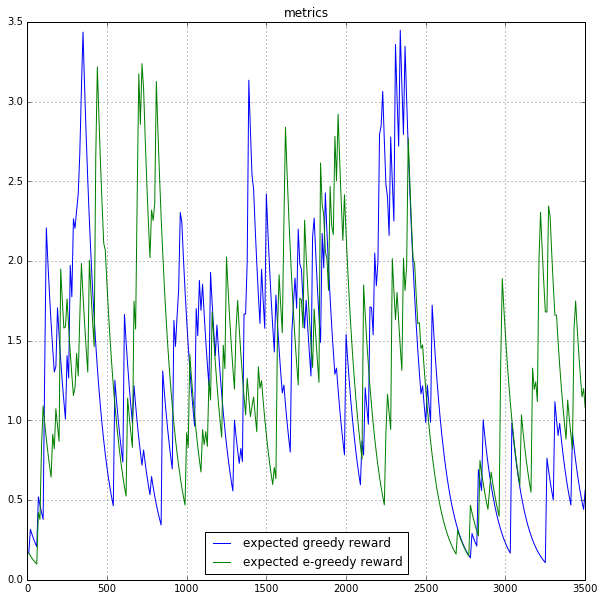

Random session examples


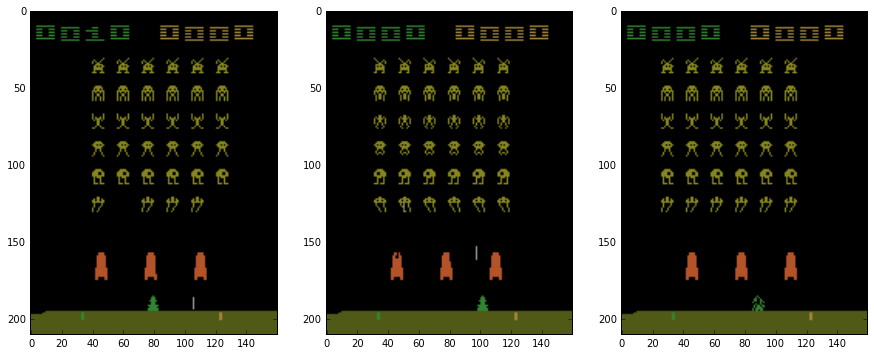

epoch 3510,loss 13.37083, epsilon 0.06345, rewards: ( e-greedy 1.63828, greedy 0.67404) 
rec 13.335 reg 0.036
epoch 3520,loss 0.03906, epsilon 0.06332, rewards: ( e-greedy 1.47445, greedy 0.60664) 
rec 0.003 reg 0.036
epoch 3530,loss 7.53787, epsilon 0.06319, rewards: ( e-greedy 1.82701, greedy 0.54597) 
rec 7.502 reg 0.036
epoch 3540,loss 0.04010, epsilon 0.06306, rewards: ( e-greedy 1.64431, greedy 0.99137) 
rec 0.004 reg 0.036
epoch 3550,loss 7.65130, epsilon 0.06293, rewards: ( e-greedy 1.97988, greedy 0.89224) 
rec 7.615 reg 0.036
epoch 3560,loss 0.03972, epsilon 0.06280, rewards: ( e-greedy 1.78189, greedy 0.80301) 
rec 0.004 reg 0.036
epoch 3570,loss 0.87188, epsilon 0.06267, rewards: ( e-greedy 1.77037, greedy 0.72271) 
rec 0.836 reg 0.036
epoch 3580,loss 13.37010, epsilon 0.06254, rewards: ( e-greedy 2.26000, greedy 1.48377) 
rec 13.334 reg 0.036
epoch 3590,loss 0.03882, epsilon 0.06242, rewards: ( e-greedy 2.03400, greedy 1.66873) 
rec 0.003 reg 0.036
epoch 3600,loss 7.53884,

KeyboardInterrupt: 

In [36]:
%%time

n_epochs = 1000

for epoch_counter in range(n_epochs):    
    
    #train
    update_pool(env, pool, replay_seq_len)
    resolver.rng.seed(i)    
    loss, avg_reward = do_training_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
#     if epoch_counter % 1 ==0:
#         current_epsilon = 0.05 + 0.45 * np.exp(- epoch_counter / 1000.)
#         resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter % 10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        score_log["expected e-greedy reward"].append(avg_reward_current)
        #ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        #score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,game_pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        score_log["expected e-greedy reward"].append(avg_reward_current)
        #ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        #score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        #back to epsilon-greedy
        current_epsilon = 0.05 + 0.45 * np.exp(- epoch_counter / 1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env, game_pool, replay_seq_len)
        print 'epoch', epoch_counter

#         print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
#             epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
#         print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter % 500 ==0:
        print "Learning curves:"
        score_log.plot()

        print "Random session examples"
        display_sessions()
    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

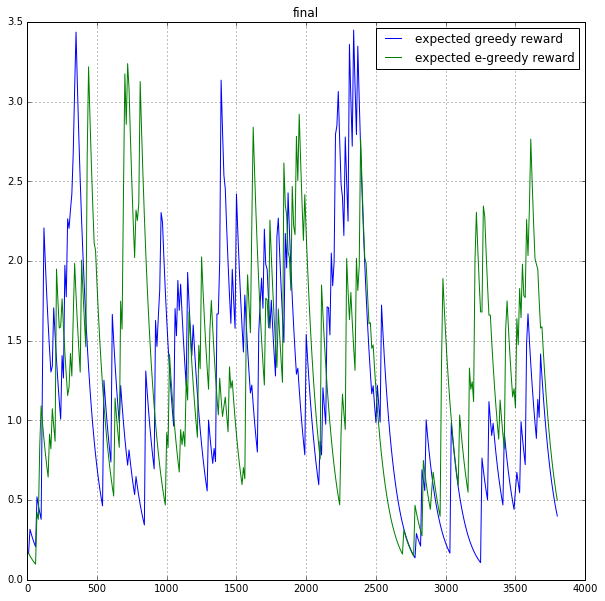

In [37]:
score_log.plot("final")

Random session examples


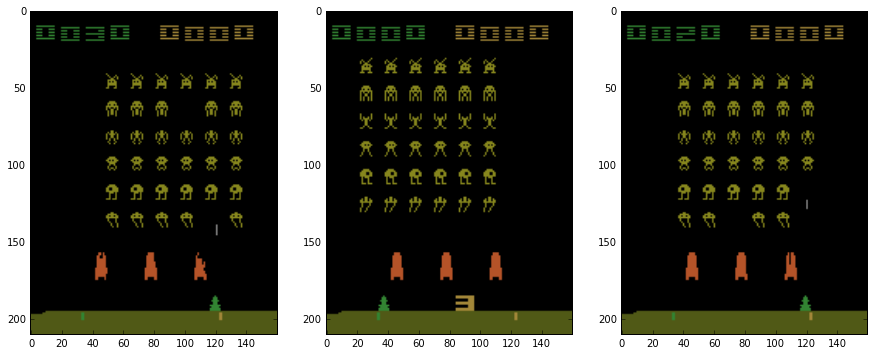

In [43]:
print "Random session examples"
display_sessions()

# Once you got it working,

Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__